# This notebook implements the training phase of the LSTM-CNN model

## Libraries importations

In [65]:
%run auxiliaryfunctions.ipynb

import numpy as np
import pandas as pd
import pickle as pk
import re, sys, os, csv, keras

from keras import regularizers, initializers, optimizers, callbacks
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec 

## Implementation of the LSTM-CNN model

### Preparing the embedding layers

- Extract the GloVe vector embedding of the words that are present in our tweets corpus word tokens list.
- Create two embedding matrixes for both the non static/static channels of the neural network.
- Construct and initialize the embedding layers based on those two matrixes

We use pre-trained [GloVe](https://nlp.stanford.edu/projects/glove/) vectors from Stanford NLP. 

In [66]:
%run Preprocessing_data.ipynb

embeddings_index = {}
f = open(GLOVE_DIR, encoding ='utf-8')
print("Loading the GloVe embeddings from:",GLOVE_DIR,"...",end="")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print("Embedding with GloVe vectors is completed!")

Tweet dataset shape: (40000, 4)
empty : @tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[
Parameters for the embedding and pre-processing:
 40000 35 0.3 200 
 dataset/glove/glove.twitter.27B.200d.txt
Reading from the csv file...Done!
Succesfully save the word tokenizer to file: tokenizer.pkl
Found 27496 unique tokens.
Shape of data tensor: (33402, 30)
Shape of label tensor: (33402, 4)
Number of entries in each category:
Training:
 [6739. 4203. 6554. 5885.]
Testing:
 [2905. 1765. 2777. 2574.]
Loading the GloVe embeddings from: dataset/glove/glove.twitter.27B.200d.txt ...Done.
 Proceeding with Embedding Matrix...Embedding with GloVe vectors is completed!


In [105]:
# second embedding matrix for non-static channel
embedding_matrix_ns = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ns[i] = embedding_vector
print("Embedding for non-static completed!")

Embedding for non-static completed!


In [106]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# static channel
embedding_layer_frozen = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)

# non-static channel
embedding_layer_train = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_ns],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences_train = embedding_layer_train(sequence_input)

## Construction of the neural network: first comes the LSTM layers, then the CNN layers.

In [107]:
l_lstm1f = Bidirectional(LSTM(5,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_frozen)
l_lstm1t = Bidirectional(LSTM(5,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_train)

l_lstm1 = Concatenate(axis=1)([l_lstm1f, l_lstm1t])

In [108]:
l_conv_2 = Conv1D(filters=20,kernel_size=2,activation='relu')(l_lstm1)
l_conv_2 = Dropout(0.3)(l_conv_2)

l_conv_3 = Conv1D(filters=20,kernel_size=3,activation='relu')(l_lstm1)
l_conv_3 = Dropout(0.3)(l_conv_3)

l_conv_5 = Conv1D(filters=20,kernel_size=5,activation='relu',)(l_lstm1)
l_conv_5 = Dropout(0.3)(l_conv_5)

l_conv_6 = Conv1D(filters=20,kernel_size=6,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_6 = Dropout(0.3)(l_conv_6)

l_conv_7 = Conv1D(filters=20,kernel_size=8,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_7 = Dropout(0.3)(l_conv_8)

conv_1 = [l_conv_6,l_conv_5, l_conv_7,l_conv_2,l_conv_3]

l_lstm_c = Concatenate(axis=1)(conv_1)

In [109]:
l_pool = MaxPooling1D(3)(l_lstm_c)
l_drop = Dropout(0.5)(l_pool)
l_flat = Flatten()(l_drop)
l_dense = Dense(26, activation='relu')(l_flat)
preds = Dense(4, activation='softmax')(l_dense)

In [110]:
import tensorflow as tf

model = Model(sequence_input, preds)
adadelta = tf.keras.optimizers.Adadelta(lr=0.9, rho=0.95, epsilon=None, decay=0.002)
lr_metric = get_lr_metric(adadelta)
model.compile(loss='categorical_crossentropy',
              optimizer=adadelta,
              metrics=['acc'])

D:\ProgramFiles\Anaconda\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Summary of the model:

In [111]:
model.summary()
model.save('LSTM-CNN.h5')

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 30, 200)      5499400     input_7[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 30, 200)      5499400     input_7[0][0]                    
__________________________________________________________________________________________________
bidirectional_18 (Bidirectional (None, 30, 10)       8240        embedding_6[0][0]                
___________________________________________________________________________________________

## Training phase of the model: 50 epochs

In [112]:
print("Training phase starting:")

tensorboard = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True)
model_checkpoints = callbacks.ModelCheckpoint("checkpoints/checkpoint-{val_loss:.3f}.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
lr_schedule = callbacks.LearningRateScheduler(initial_boost)

model_log = model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=50, batch_size=200,
          callbacks=[tensorboard, model_checkpoints])

Training phase starting:


Epoch 1/50
117/117 [==============================] - 23s 150ms/step - loss: 1.3679 - acc: 0.3214 - val_loss: 1.3539 - val_acc: 0.3503
Epoch 2/50
117/117 [==============================] - 19s 159ms/step - loss: 1.3121 - acc: 0.3795 - val_loss: 1.2763 - val_acc: 0.4099
Epoch 3/50
117/117 [==============================] - 18s 158ms/step - loss: 1.2620 - acc: 0.4156 - val_loss: 1.2511 - val_acc: 0.4246
Epoch 4/50
117/117 [==============================] - 18s 156ms/step - loss: 1.2409 - acc: 0.4328 - val_loss: 1.2356 - val_acc: 0.4319
Epoch 5/50
117/117 [==============================] - 18s 154ms/step - loss: 1.2279 - acc: 0.4424 - val_loss: 1.2261 - val_acc: 0.4438
Epoch 6/50
117/117 [==============================] - 18s 156ms/step - loss: 1.2188 - acc: 0.4489 - val_loss: 1.2221 - val_acc: 0.4466
Epoch 7/50
117/117 [==============================] - 18s 157ms/step - loss: 1.2116 - acc: 0.4510 - val_loss: 1.2176 - val_acc: 0.4567
Epoch 8/50
117/117 [==============================] - 1

In [113]:
pd.DataFrame(model_log.history).to_csv("balance_history.csv")

## Prediction phase: let us test the model on the same tweets dataset

In [114]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools, pickle

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

classes = ["serious", "happy", "fun", "caring"]


In [115]:
Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)

In [116]:
print(classification_report(Y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

     serious       0.46      0.53      0.50      2905
       happy       0.40      0.27      0.32      1765
         fun       0.45      0.44      0.44      2777
      caring       0.50      0.55      0.52      2574

    accuracy                           0.46     10021
   macro avg       0.45      0.45      0.45     10021
weighted avg       0.46      0.46      0.46     10021



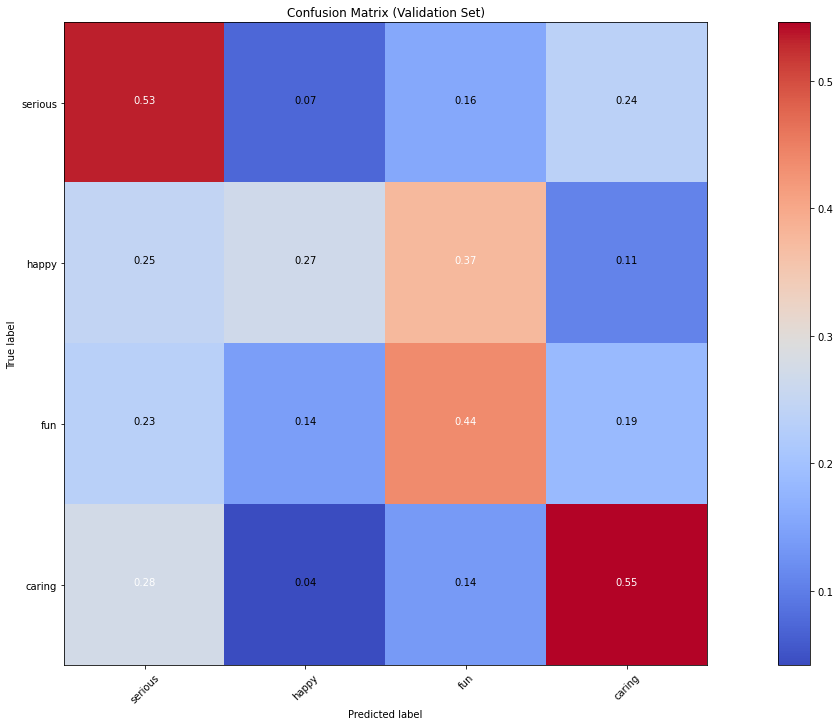

In [117]:
#code obtained from https://mikesmales.medium.com/sound-classification-using-deep-learning-8bc2aa1990b7
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=classes, cmap= plt.cm.coolwarm)

# precision = true_pos / (true_pos + false_pos)
# recall = true_pos / (true_pos + false_neg)

In [118]:
model.save('sentiment_classifier_final.h5')

In [119]:
model_final = load_model('sentiment_classifier_final.h5')